## Project: Object localizer

The first part of this notebook deals with object localization utilizing a pre-trained model based on the VGG16 model.

 - We first start considering a randomly placed image without background.
 - In part 2, we include a background.
 - In part 3, we include an additional classification task by identifying whether there is an object in the background or not.

![alt text](output.jpg "Theo")

In [1]:
#!pip install tensorflow==2.15.0

In [2]:
!python3 --version

Python 3.11.9


In [3]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image

In [5]:
# set a random state number
rs = 42

os.environ['PYTHONHASHSEED']=str(rs)
import random
random.seed(rs)
np.random.seed(rs)

In [6]:
import tensorflow as tf
from keras.applications import VGG16

from keras.models import Model
from keras.layers import Flatten, Dense, Concatenate

### Image data Generator

In [7]:
def load_image(image_path, target_size=(224, 224)):
    """
    Load an image from a file and resize it to the target size
    Returns the loaded and resized image as a numpy array
    """
    image = Image.open(image_path)
    image = image.resize(target_size)
    image = np.array(image)
    return image

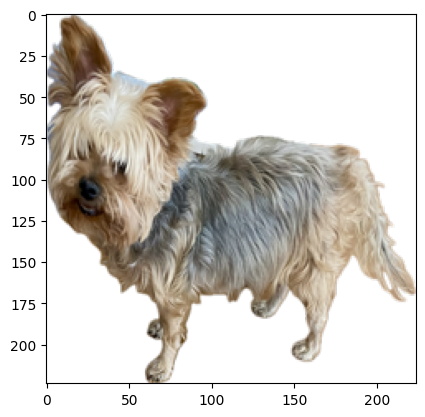

In [8]:
image = load_image("Theo.png")
plt.imshow(image)

shape of png image (224, 224, 4)


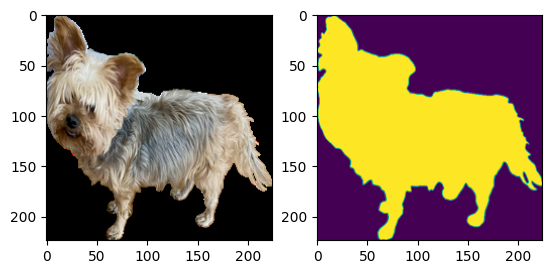

In [9]:
# PNG images has a fourth channel called alpha channel.
# It basically tells which pixels will be transparent.
imagepng = np.array(image)
print("shape of png image", np.array(imagepng).shape)

# use subplot to plot two images
fig, ax = plt.subplots(1, 2)
ax[0].imshow(imagepng[:,:,:3])
ax[1].imshow(imagepng[:,:,3])
plt.show()


In [10]:
epochs = 6

n_batches_epoch = 50

batch_size = 64

# define the target size of the images
IMG_DIM = 224

In [11]:
def paste_image(background, foreground, target_size_background=(224, 224),
                target_size_foreground=(70, 70)):
    """
    function to paste a randomly placed foreground image on a background image
    input:
        background: PIL image object of the background image
        foreground: PIL image object of the foreground image
        target_size_background: target size of the background image
        target_size_foreground: target size of the foreground image
    output:
        background_img: image with the foreground image pasted on it
        row0: starting row of the pasted image
        col0: starting column of the pasted image
        row1: ending row of the pasted image
        col1: ending column of the pasted image
    """

    # resize the images and convert them to numpy arrays
    background_img = background.resize(target_size_background)
    foreground_img = foreground.resize(target_size_foreground)
    background_img = np.array(background_img)
    foreground_img = np.array(foreground_img)

    # randomly flip the foreground image
    if np.random.rand() > 0.5:
        foreground_img = np.fliplr(foreground_img)

    # define random slices to paste dog image on background image
    # in such a way that it doesn't go out of bounds
    TH_H, TH_W, _ = foreground_img.shape
    row0 = np.random.randint(target_size_background[0] - TH_H)
    col0 = np.random.randint(target_size_background[1] - TH_W)
    row1 = row0 + TH_H
    col1 = col0 + TH_W

    # create a mask for the dog image using the alpha channel
    mask = (np.array(foreground_img)[:,:,3] == 0)

    # Define the background slice using the mask
    slice = background_img[row0:row1, col0:col1,:] * (mask[:,:,None])

    # Paste the dog image on the background image
    background_img[row0:row1, col0:col1,:] = slice + foreground_img[:,:,:3] * (~mask[:,:,None])

    return background_img, row0, col0, row1, col1

---

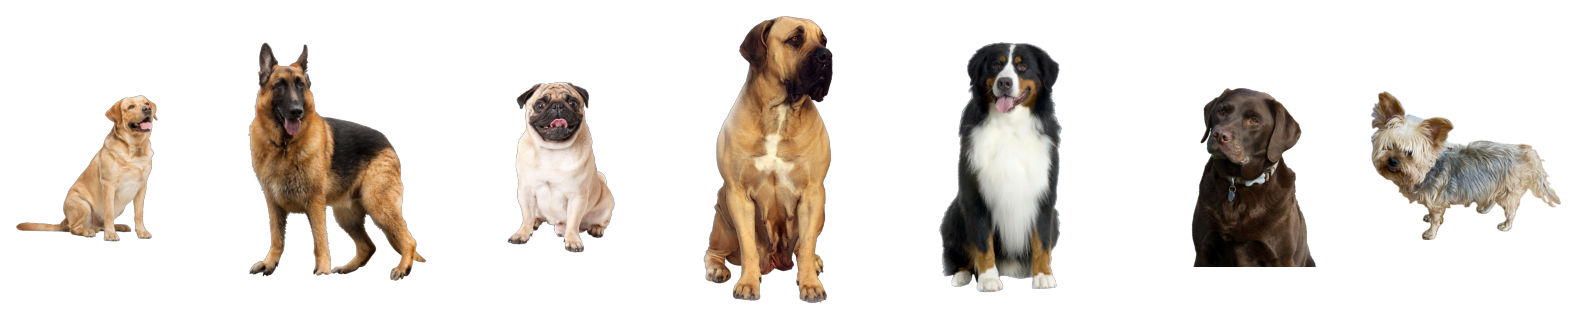

In [12]:
# define the directory path for the images
object = "dogs"
object_list = os.listdir(object)

# plot the images in the directory dogs
fig, ax = plt.subplots(1, 7, figsize=(20, 20))
for i in range(7):
    image = Image.open(os.path.join(object, object_list[i]))
    ax[i].imshow(image)
    ax[i].axis("off")

Identifying if there is an image or not is achieved by including an additional final layer in the model.

 - since this is a binary classification, `softmax` and `binary_crossentropy` are good options.
 - However, the Loss function has to be customized to include weights.
  

Firstly I would need to modify the generator to randomly paste the object on the background or not.

In case it doens't paste the object, it returns the backgroun, row0, col0, row1, col1 equal to zero.

In [13]:
def image_generator3(background, object, batch_size=64, IMG_DIM=224):
    """
    This generator randomly pastes a dog image on a background image.
    In case it doesn't paste the dog image, it will generate X: a background image, and Y: will be all zeros.
    input:
        background: path to the folder containing the background images
        batch_size: [optional] number of images to generate
        IMG_DIM: [optional] target size of the images
    output:
        X: numpy array of the images (batch_size, IMG_DIM, IMG_DIM, 3)
        Y: numpy array of the labels (batch_size, 12)
    """

    # generate an array of size batch_size
    #number of dimentional classes
    num_classes = 5 
    # number of breeds to be classified
    dog_class = 7

    X = np.zeros((batch_size, IMG_DIM, IMG_DIM, 3))
    y_size = dog_class + num_classes
    Y = np.zeros((batch_size, y_size)) # (row0, col0, height, width, is_dog, object_class[7])

    while True:
        # iterates over n_batches per epoch (an arbitrary number).
        for i in range(batch_size):

            # get a list of all the object images as object_list
            object_list = os.listdir(object)
            # create a dictionary of the object images {path_to_object: class_number}
            object_dict = {os.path.join(object, object_list[i]): i for i in range(0, len(object_list))}
            # chose a random image from the object_list
            object_image_path = os.path.join(object, 
                                             np.random.choice(object_list))
            object_image = Image.open(object_image_path) # load the dog image as PIL object
            object_class = int(object_dict.get(object_image_path)) # object_class is a integer

            
            # get a list of all the background images as background_list
            background_list = os.listdir(background)
            background_list = [os.path.join(background, i) for i in background_list]
            # chose a random image from the background_list
            background_image_path = np.random.choice(background_list)
            background_image = Image.open(background_image_path) # load the background image as PIL object

            # randomly choose to paste the dog image or not
            is_dog = np.random.random()
            if is_dog < 0.3:
                # don't paste the dog image
                X[i,:,:,:] = background_image.resize((IMG_DIM, IMG_DIM))
                Y[i,:] = 0.

            else:
                # paste a random size for the dog image on the background image
                size_theo = int(random.uniform(0.25, 0.75) * IMG_DIM)

                image, row0, col0, row1, col1 = paste_image(
                    background_image, object_image,
                    target_size_background=(IMG_DIM, IMG_DIM),
                    target_size_foreground=(size_theo, size_theo)
                    )

                X[i,:,:,:] = image[:, :, :3]

                # The labels Y are normalized coordinates and dimensions relative to the (IMG_DIM, IMG_DIM) image.
                Y[i,:] = 0.
                Y[i,0] = row0 / IMG_DIM
                Y[i,1] = col0 / IMG_DIM
                Y[i,2] = (row1 - row0) / IMG_DIM
                Y[i,3] = (col1 - col0) / IMG_DIM
                Y[i,4] = 1.
                Y[i, 5 + object_class] = 1. # one-hot encoding of the object class
                # Y = (row0 / Dim, col0 / Dim, height / Dim, width / Dim, is_dog, object_class)

        yield X / 255. , Y


Create a dictionary of the object images `{class_number: object_name}`

In [14]:
object = "dogs"
object_list = os.listdir(object)
object_dict_name = {i: os.path.join(object, object_list[i]).split("/")[-1].split(".")[0] 
                                for i in range(0, len(object_list))}
object_dict_name

{0: 'Golden_Retriever',
 1: 'German_Shepherd',
 2: 'Pug',
 3: 'Boxer',
 4: 'Bernese_mountain',
 5: 'Labrador_retriever',
 6: 'Yorkshire_terrier'}

Test the generator on random images

In [15]:
def test_generator(test_batch_size=4):

  for i in image_generator3(background="background", object="dogs", batch_size=test_batch_size, IMG_DIM=224):
    ind = 0
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    for k in range(2):
      for l in range(2):
        #print(k,l,ind)
        ax[k,l].imshow(i[0][ind])
        p = i[1][ind] # row0, col0, height, width, is_dog
        
        is_dog = bool(p[4])
        if is_dog:
          class_number = p[5:].argmax()
          class_name = object_dict_name.get(class_number)
        else:
          class_name = "None"

        p = p[:-2] * IMG_DIM # [row0, col0, height, width] * Dim
        rec = plt.Rectangle((p[1] , p[0]), p[3] , p[2],
                          linewidth=1, edgecolor='r', facecolor='none')
        ax[k,l].add_patch(rec)
        ax[k,l].set_title(f"p: {p}, is_dog: {is_dog}, class_name: {class_name}")
        ind += 1
    plt.show() 
    break
  return

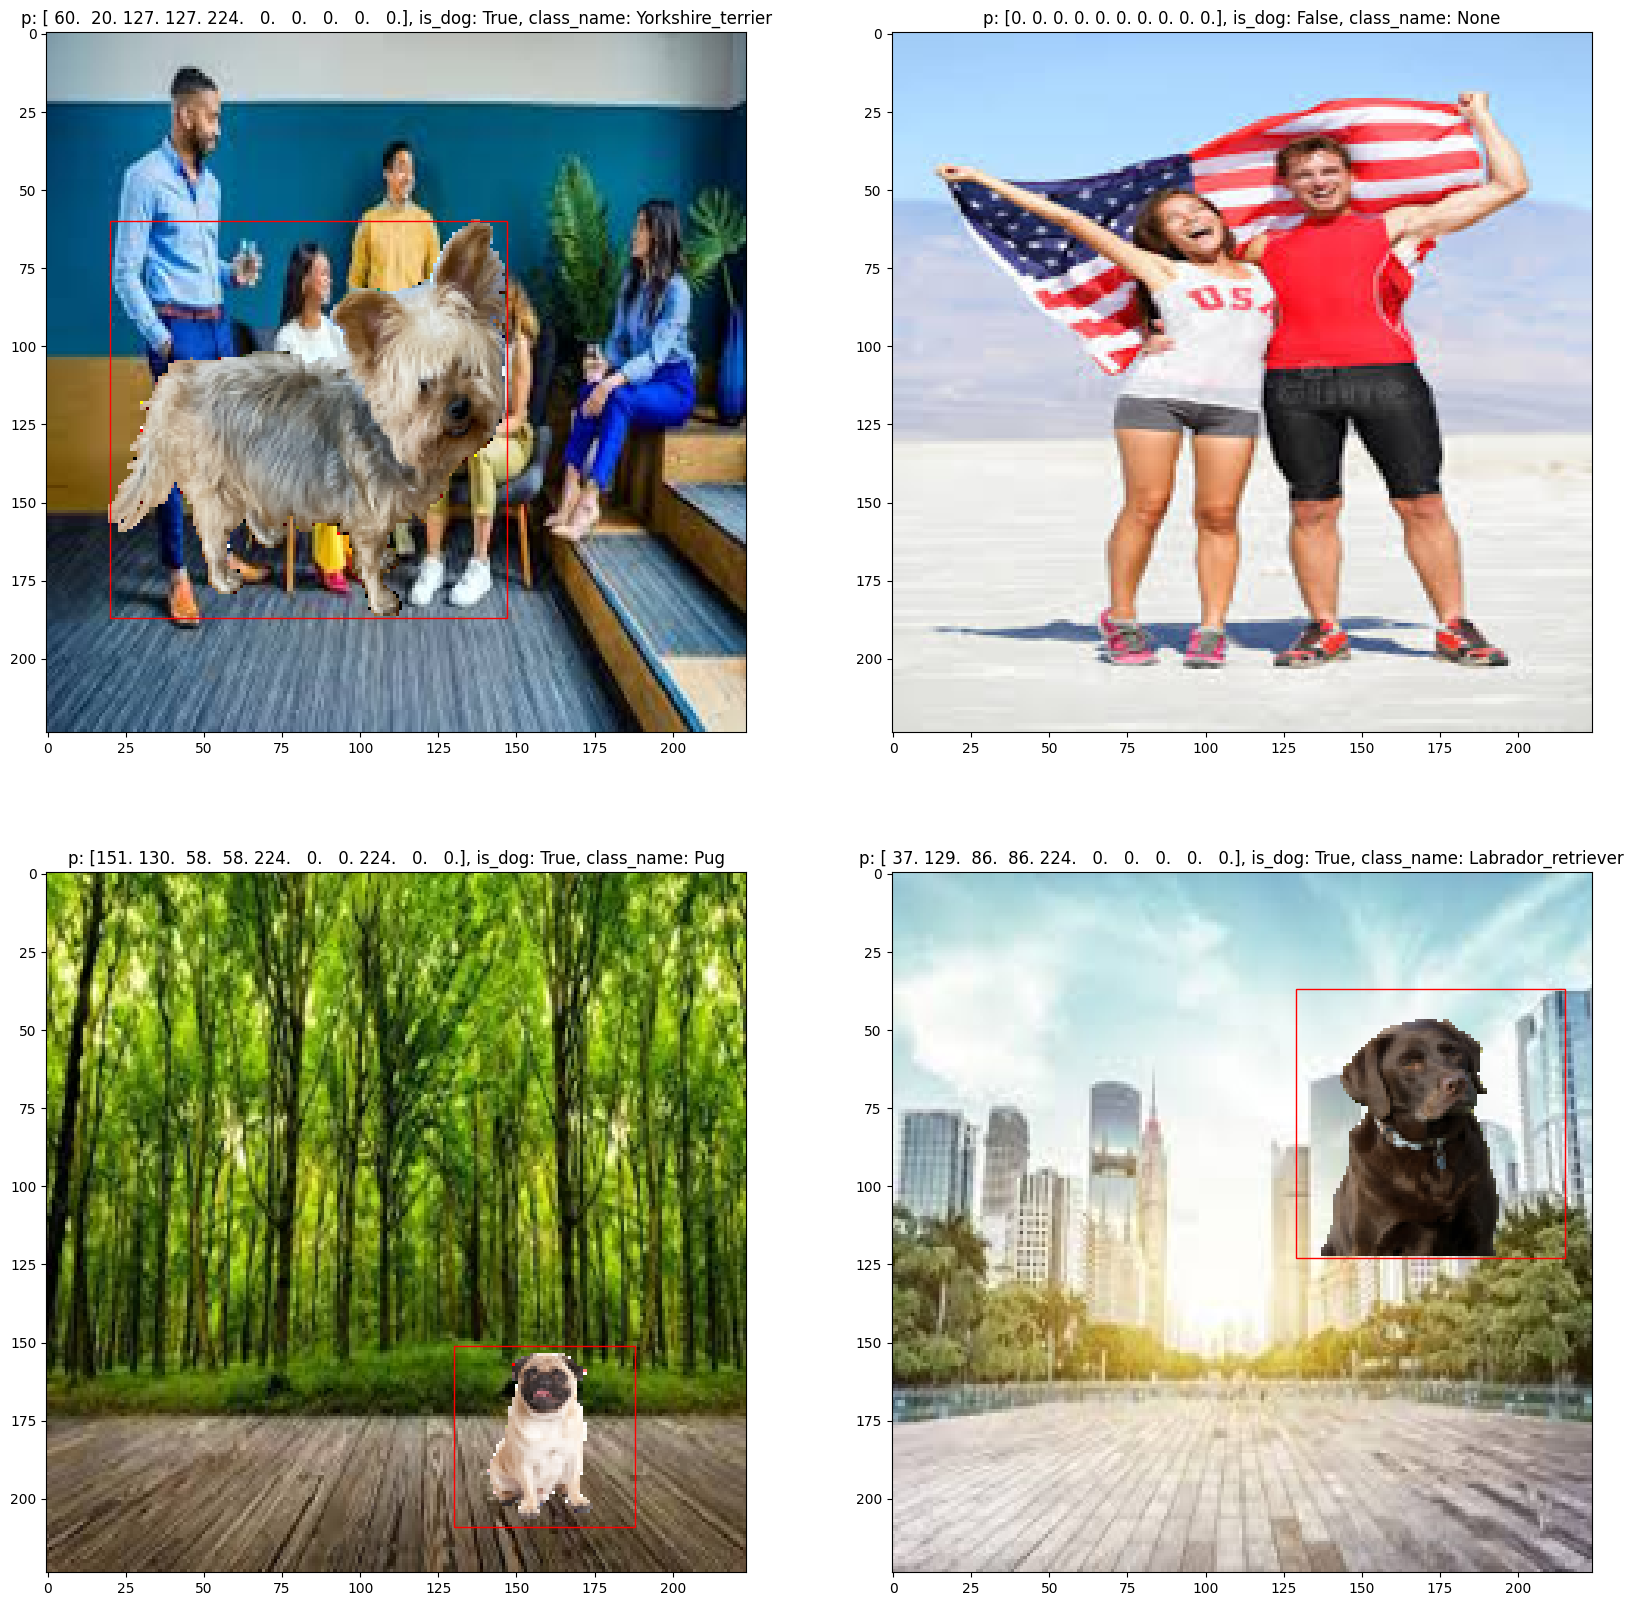

In [16]:
test_generator()

### Model Definition

In [17]:
def custom_loss(y_true, y_pred):
    """
    Custom loss function to calculate the loss of the model.

    Target values are expected to be in the following order:
    (row0, col0, height, width, is_dog, object_class)

    The loss function is a combination of three losses:
    - detection_loss: [binary_crossentropy] is the loss for the (is_dog) binary class
    - box_loss: [binary_crossentropy] is the loss for (row0, col0, height, width) values.
    - class_loss: [categorical_crossentropy] is the loss for the (object_class) with 7 classes.
    
    box_loss and class_loss are weighted by the is_dog_true value

    The binary_crossentropy loss function is defined as:
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    """

    # separate the box and is_dog values from y_true, y_pred
    box_true = tf.cast(y_true[:,:4], tf.float64) # up to width
    box_pred = tf.cast(y_pred[:,:4], tf.float64)
    is_dog_true = tf.cast(y_true[:,4], tf.float64) # is_dog
    is_dog_pred = tf.cast(y_pred[:,4], tf.float64)
    class_true = tf.cast(y_true[:,5:], tf.float64) # object_class as one-hot
    class_pred = tf.cast(y_pred[:,5:], tf.float64)

    # calculate the loss
    box_loss = tf.keras.losses.binary_crossentropy(box_true, box_pred)
    detection_loss = tf.keras.losses.binary_crossentropy(is_dog_true, is_dog_pred)
    class_loss = tf.keras.losses.categorical_crossentropy(class_true, class_pred)

    loss = (detection_loss + tf.reduce_mean(box_loss * is_dog_true) + tf.reduce_mean(class_loss * is_dog_true)) / 3.

    return loss

In [18]:
def model_vgg16_v2():
    # The model is very similar to the previous model, but the number of classes is 5 now.
    # I have included an additional class to indicate if the dog image is pasted on the background image or not.
    
    num_classes = 5 # row0, col0, height, width, is_dog, 
    
    dog_class = 7 # number of classes for the dog images

    base_model = VGG16(input_shape=[IMG_DIM, IMG_DIM, 3],
                       weights='imagenet', include_top=False)
    x = base_model.output

    x = Flatten()(x)

    x = Dense(1024, activation='relu')(x)

    x1 = Dense(num_classes, activation='sigmoid')(x)
    x2 = Dense(dog_class, activation='softmax')(x)

    x = Concatenate()([x1, x2])

    model = Model(inputs=base_model.input, outputs=x)

    #Freeze layers from VGG16 backbone (not to be trained)
    for layer in base_model.layers:
        layer.trainable=False

    return model

In [19]:
model3 = model_vgg16_v2()

model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [20]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

In [21]:
@tf.function
def train_step(X, Y):
    """ Function to train the model using the custom loss function """
    
    with tf.GradientTape() as tape:
        loss = custom_loss(Y, model3(X))

    gradients = tape.gradient(loss, model3.trainable_variables)
    opt.apply_gradients(zip(gradients, model3.trainable_variables))
    return loss

In [22]:
def train_model(epochs, n_batches_epoch, batch_size):
    """ Function to train the model for a number of epochs """

    loss_values = []
    for i in range(1, epochs + 1):
        print(f"Epoch: {i}/{epochs}" )
        print(f" {n_batches_epoch}/{n_batches_epoch}  [", end="")
        for j in range(n_batches_epoch):
            X, Y = next(image_generator3(background="background", 
                        object="dogs", batch_size=batch_size, IMG_DIM=IMG_DIM)
                        )
            loss = train_step(X, Y)
            if j % 3 == 0:
                print("==", end="")
        loss_values.append(loss)
        print(f"] -  Loss: {loss}")
        
    return loss_values

In [23]:
%%time

print("training started")
print("epochs: ", epochs, ", n_batches_epoch: ", n_batches_epoch)

# train the model
start_datetime = datetime.now()

loss_values = train_model(epochs, n_batches_epoch, batch_size)

end_datetime = datetime.now()
print("Training time: ", end_datetime - start_datetime)

training started
epochs:  6 , n_batches_epoch:  50
Epoch: 1/6
 50/50  [==================================] -  Loss: 0.3420810569201681
Epoch: 2/6
 50/50  [==================================] -  Loss: 0.315720242891598
Epoch: 3/6
 50/50  [==================================] -  Loss: 0.3189576518973393
Epoch: 4/6
 50/50  [==================================] -  Loss: 0.23753102879758808
Epoch: 5/6
 50/50  [==================================] -  Loss: 0.24294908557172534
Epoch: 6/6
 50/50  [==================================] -  Loss: 0.2753637227536931
Training time:  0:35:00.132249
CPU times: user 3h 18s, sys: 4min 28s, total: 3h 4min 46s
Wall time: 35min


In [24]:
#save the model as h5
model3.save("model4-v2.h5")

/Users/brncat/Downloads/AltaVerde/GitHub/object_localizer/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
def make_prediction3(background, object, model, IMG_DIM=224):
    """
    Generate a ramdom image and make predictions.
    Also consider whether the dog image is pasted on the background image or not.
    """

    # get a list of all the object images as object_list
    object_list = os.listdir(object)
    # create a dictionary of the object images {path_to_object: class_number}
    object_dict = {os.path.join(object, object_list[i]): i for i in range(0, len(object_list))}
    # chose a random image from the object_list
    object_image_path = os.path.join(object, 
                                    np.random.choice(object_list))
    object_image = Image.open(object_image_path) # load the dog image as PIL object
    true_dog_class = int(object_dict.get(object_image_path)) # object_class is a integer


    # get a list of all the background images as background_list
    background_list = os.listdir(background)
    background_list = [os.path.join(background, i) for i in background_list]
    # Chose a random image from the background_list
    background_image_path = np.random.choice(background_list)
    background_image = Image.open(background_image_path) # load the background image as PIL object

    # decide whether to paste the dog image or not
    is_dog = np.random.random()
    if is_dog < 0.3:
        # don't paste the dog image
        x = background_image.resize((IMG_DIM, IMG_DIM))
        print("no dog")

        # make a prediction
        x_pred = np.expand_dims(x, 0) / 255.
        p = model.predict(x_pred)[0]
        print("pred: ", p[:5])
        plt.imshow(background_image.resize((IMG_DIM, IMG_DIM)))
    
    else:
        # paste a random size for the dog image on the background image
        size_theo = int(random.uniform(0.25, 0.75) * IMG_DIM)
        x, row0, col0, row1, col1 = paste_image(
                    background_image, object_image,
                    target_size_background=(IMG_DIM, IMG_DIM),
                    target_size_foreground=(size_theo, size_theo)
                    )
        print("true:", row0, col0, row1, col1)

        # make a prediction
        x_pred = np.expand_dims(x, 0) / 255. # (224, 224, 3) -> (1, 224, 224, 3)
        p = model.predict(x_pred)[0]

        # calculate target values
        # y = np.zeros(5 + num_classes)
        # y[0] = row0 / IMG_DIM
        # y[1] = col0 / IMG_DIM
        # y[2] = (row1 - row0) / IMG_DIM # = TH_H / IMG_DIM
        # y[3] = (col1 - col0) / IMG_DIM # = TH_W / IMG_DIM
        # y[4] = int(is_dog > 0.5) # 0 or 1
        # y[5 + object_class] = 1. # one-hot encoding of the object class

        # draw the predicted box
        row0 = int(p[0] * IMG_DIM)
        col0 = int(p[1] * IMG_DIM)
        row1 = int(row0 + (p[2] * IMG_DIM))
        col1 = int(col0 + (p[3] * IMG_DIM))
        pred_dog_class = p[5:].argmax()
        print("pred box:", row0, col0, row1, col1)

        is_dog = bool(p[4])
        if is_dog:
            print("is_dog:", is_dog, ", pred class:", object_dict_name.get(pred_dog_class),
                  ", true class:", object_dict_name.get(true_dog_class))
        else:
            print("is_dog:", is_dog)
        
        fig, ax = plt.subplots(1)
        ax.imshow(x.astype(np.uint8))
        rect = plt.Rectangle((p[1] * IMG_DIM , p[0] * IMG_DIM), p[3]* IMG_DIM , p[2]* IMG_DIM ,
                         linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

In [26]:
# load the model
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'custom_loss': custom_loss})

model4 = tf.keras.models.load_model("model4-v2.h5")

true: 38 130 129 221
1/1 [==============================] - 0s 159ms/step
pred box: 37 106 119 196
is_dog: True , pred class: German_Shepherd , true class: German_Shepherd


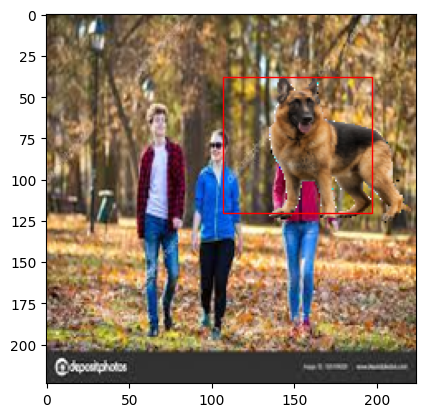

In [27]:
make_prediction3(background='background', object="dogs", model=model4)


true: 104 66 204 166
1/1 [==============================] - 0s 96ms/step
pred box: 111 76 195 161
is_dog: True , pred class: Pug , true class: Pug


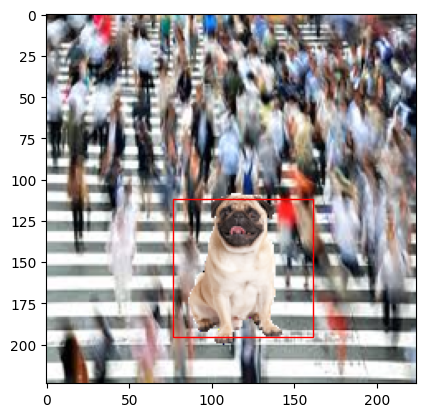

In [28]:
make_prediction3(background='background', object="dogs", model=model4)

true: 30 48 107 125
1/1 [==============================] - 0s 98ms/step
pred box: 21 34 89 113
is_dog: True , pred class: Bernese_mountain , true class: Bernese_mountain


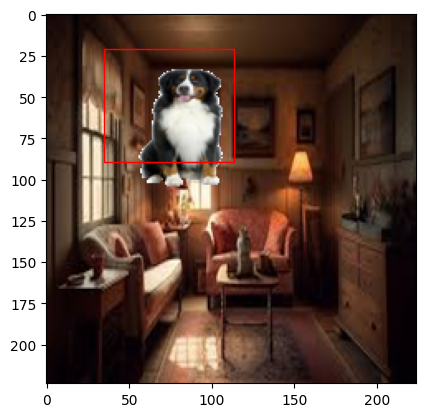

In [29]:
make_prediction3(background='background', object="dogs", model=model4)

no dog
1/1 [==============================] - 0s 128ms/step
pred:  [0.30933616 0.39595863 0.30802488 0.318761   0.05888185]


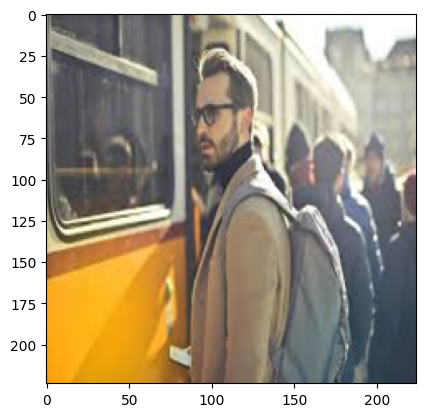

In [30]:
make_prediction3(background='background', object="dogs", model=model4)

true: 26 22 163 159
1/1 [==============================] - 0s 94ms/step
pred box: 19 10 157 158
is_dog: True , pred class: Labrador_retriever , true class: Labrador_retriever


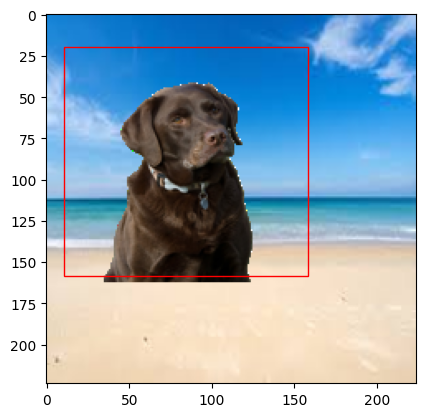

In [31]:
make_prediction3(background='background', object="dogs", model=model4)

Overall we clearly see that the model does pretty well in identifying the bounding boxes and the dog's breeds. Besides it also does very well in determining whether there is a dog or not.

---

Finally, let us make some prediction on real images of dogs

In [32]:
def prediction(model, image):
    #load the image
    x = load_image(image_path=image, target_size=(224, 224))
    xp = np.expand_dims(x, 0) / 255.
    p = model.predict(xp)[0]
    
    # get bounding box values
    row0 = int(p[0] * 224)
    col0 = int(p[1] * 224)
    row1 = int(row0 + (p[2] * 224))
    col1 = int(col0 + (p[3] * 224))
    print("pred box:", row0, col0, row1, col1)

    # get the class name
    is_dog = bool(p[4])
    if is_dog:
        class_number = p[5:].argmax()
        class_name = object_dict_name.get(class_number)
    else:
        class_name = "None"
    print("is_dog:", is_dog, ", class_name:", class_name)
    
    # plot the image

    p = p * 224
    plt.imshow(x)
    plt.gca().add_patch(plt.Rectangle((p[1], p[0]), p[3], p[2], color='r', fill=False))
    plt.title(f"Pred class name: {class_name}")
    plt.show()

    return


1/1 [==============================] - 0s 95ms/step
pred box: 51 35 153 148
is_dog: True , class_name: German_Shepherd


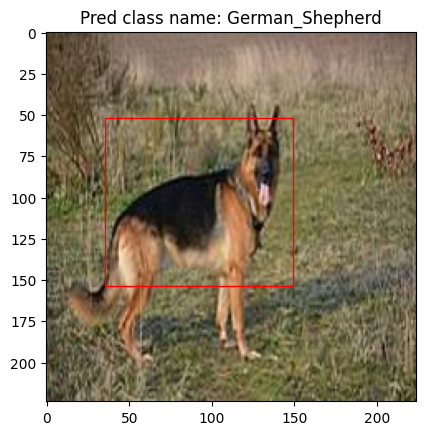

In [34]:
prediction(model=model4, image="/Users/brncat/Downloads/GS.jpg")